In [2]:
import jphot as jp
import lya_utils as lya
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import os

In [3]:
def write_param_PFSM(file,lmin,lmax,nphot,outputFile,l0=1190.,beta=0.):
    import lya_utils as lya
    f = open(file,'w')
    f.write('!--------------------------------------------------------------------------------\n')
    f.write('[PhotonsFromSourceModel]\n')
    f.write('# input / output parameters \n')
    f.write('outputfile = %s \n'%(outputFile))
    f.write('# computational domain parameters \n')
    f.write('source_type = pointlike \n')
    f.write('source_pos  = 0.5 0.5 0.5 \n')
    f.write('spec_type = PowLaw \n')
    f.write('spec_powlaw_lmin_Ang = %e \n'%(lmin))
    f.write('spec_powlaw_lmax_Ang = %e \n'%(lmax))
    f.write('spec_powlaw_l0_Ang = %e \n'%(l0))
    f.write('spec_powlaw_beta = %e \n'%(beta))
    f.write('# miscelaneous parameters \n')
    f.write('nphot           = %i \n'%(nphot))
    f.write('ranseed         = -100 \n')
    f.write('verbose         = T \n')
    f.write('!--------------------------------------------------------------------------------\n')
    f.close()
    
def write_params_RaS(file,PhotICFile,outputFile,boxsize_cm=3.0e13):
    f = open(file,'w')
    f.write('!--------------------------------------------------------------------------------\n')
    f.write('[RASCAS-serial]\n')
    f.write('DataDir      = ./\n')
    f.write('DomDumpFile  = domain_decomposition_params.dat\n')
    f.write('PhotonICFile = %s\n'%(PhotICFile))
    f.write('fileout      = %s\n'%(outputFile))
    f.write('verbose      = T\n')
    f.write('!--------------------------------------------------------------------------------\n')
    f.write('\n')
    f.write('!--------------------------------------------------------------------------------\n')
    f.write('[gas_composition] \n')
    f.write('# overwrite parameters\n')
    f.write('gas_overwrite       = T\n')
    f.write('fix_nSiII = 1.0d0\n')
    f.write('fix_vth   = 1.0d4\n')
    f.write('fix_vel   = 0.0d0\n')
    f.write('fix_box_size_cm = %e\n'%(boxsize_cm))
    f.write('# miscelaneous parameters\n')
    f.write('verbose             = T\n')
    f.write('!--------------------------------------------------------------------------------\n')
    f.close()


In [4]:
# generate PhotICs around 1190.A and run RASCAS
l90 = 1190.42
dl = 0.01
write_param_PFSM('params_PFSM_1190.dat',l90-dl,l90+dl,500000,'PhotICs_1190.dat')
os.system('../../f90/PhotonsFromSourceModel params_PFSM_1190.dat > PFSM_1190.log')
write_params_RaS('params_RaS_1190.dat','PhotICs_1190.dat','result_1190_3e13.dat',boxsize_cm=3e13)
os.system('../../f90/rascas-serial params_RaS_1190.dat > RaS_1190.log')

0

In [5]:
# generate PhotICs around 1193 A and run RASCAS
l93 = 1193.28
dl = 0.01
write_param_PFSM('params_PFSM_1193.dat',l93-dl,l93+dl,500000,'PhotICs_1193.dat')
os.system('../../f90/PhotonsFromSourceModel params_PFSM_1193.dat > PFSM_1193.log')
write_params_RaS('params_RaS_1193.dat','PhotICs_1193.dat','result_1193_3e13.dat',boxsize_cm=3e13)
os.system('../../f90/rascas-serial params_RaS_1193.dat > RaS_1193.log')

0

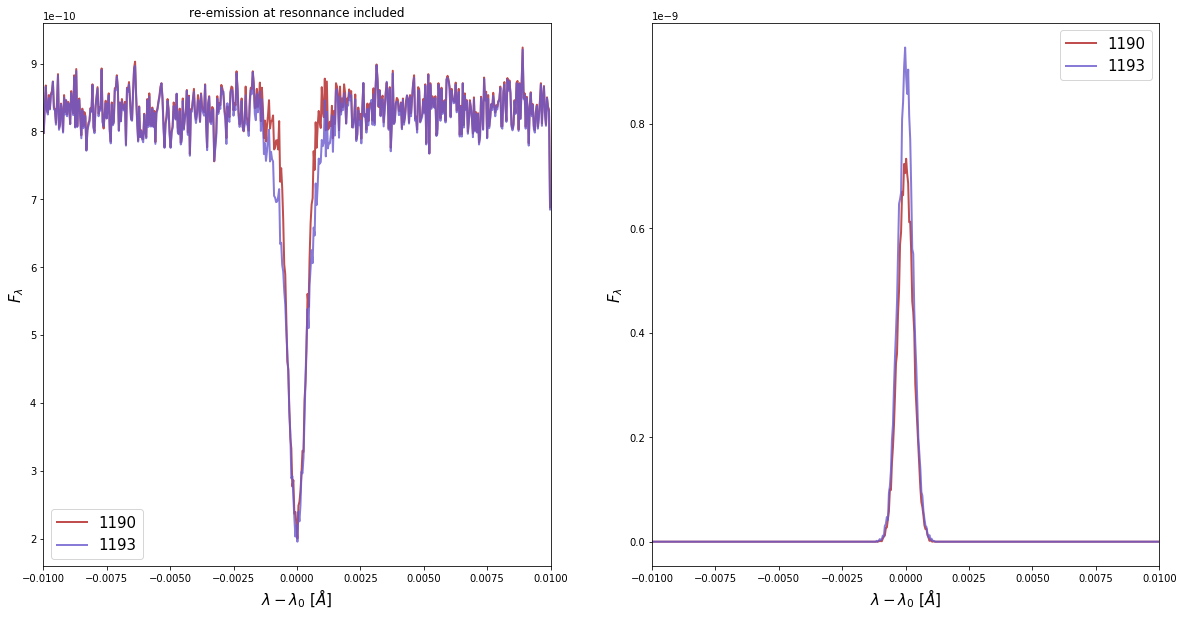

In [6]:
# fluorescent wavelengths
l93bis =1197.39
l90bis =1194.5

p = jp.photonlist('PhotICs_1190.dat','result_1190_3e13.dat')
x90fluo,h90fluo = p.spectrum(frame='obs',nbins=500,lmin=l90bis-dl,lmax=l90bis+dl)
x90reso,h90reso = p.spectrum(frame='obs',nbins=500,lmin=l90-dl,lmax=l90+dl)
p = jp.photonlist('PhotICs_1193.dat','result_1193_3e13.dat')
x93fluo,h93fluo = p.spectrum(frame='obs',nbins=500,lmin=l93bis-dl,lmax=l93bis+dl)
x93reso,h93reso = p.spectrum(frame='obs',nbins=500,lmin=l93-dl,lmax=l93+dl)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(x90reso-l90,h90reso,label='1190',color='FireBrick',linewidth=2,alpha=0.8)
plt.plot(x93reso-l93,h93reso,label='1193',color='SlateBlue',linewidth=2,alpha=0.8)
plt.legend(fontsize=15)
plt.xlim(-dl,dl)
plt.xlabel(r'$\lambda-\lambda_0 \ [\AA]$',fontsize=15)
plt.ylabel(r'$F_\lambda$',fontsize=15)
plt.title('re-emission at resonnance included')

plt.subplot(1,2,2)
plt.plot(x90fluo-l90bis,h90fluo,label='1190',color='FireBrick',linewidth=2,alpha=0.8)
plt.plot(x93fluo-l93bis,h93fluo,label='1193',color='SlateBlue',linewidth=2,alpha=0.8)
plt.legend(fontsize=15)
plt.xlim(-dl,dl)
plt.xlabel(r'$\lambda-\lambda_0 \ [\AA]$',fontsize=15)
plt.ylabel(r'$F_\lambda$',fontsize=15)
